In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [ ]:
! kaggle datasets download -d virajbagal/roco-dataset

Dataset URL: https://www.kaggle.com/datasets/virajbagal/roco-dataset
License(s): CC0-1.0
100% 6.19G/6.19G [01:02<00:00, 93.0MB/s]
100% 6.19G/6.19G [01:02<00:00, 107MB/s] 


In [ ]:
!unzip roco-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: all_data/validation/radiology/images/PMC3870636_CRIM.OTOLARYNGOLOGY2013-650428.002.jpg  
  inflating: all_data/validation/radiology/images/PMC3870648_CRIM.DENTISTRY2013-378062.012.jpg  
  inflating: all_data/validation/radiology/images/PMC3871037_enm-28-326-g001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872022_CRIM.MEDICINE2013-653925.001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872161_CRIM.SURGERY2013-209494.001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872390_CRIM.OBGYN2013-906351.001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872571_OJO-6-193-g005.jpg  
  inflating: all_data/validation/radiology/images/PMC3872571_OJO-6-193-g007.jpg  
  inflating: all_data/validation/radiology/images/PMC3872649_SNI-4-150-g001.jpg  
  inflating: all_data/validation/radiology/images/PMC3872649_SNI-4-150-g014.jpg  
  inflating: all_data/validation/radiology/images/PMC38

In [ ]:
BASE_DIR = '/content/all_data/train/radiology'
WORKING_DIR = '/content/'

In [ ]:
import csv

# Path to the CSV file
input_csv_path = '/content/all_data/train/radiology/traindata.csv'
# Path to the output text file
output_txt_path = '/content/all_data/train/radiology/output.txt'

# Open the CSV file and the output text file
with open(input_csv_path, 'r') as csv_file, open(output_txt_path, 'w') as txt_file:
    csv_reader = csv.DictReader(csv_file)  # Read the CSV file as a dictionary

    for row in csv_reader:
        name = row['name']  # Get the 'name' column
        caption = row['caption']  # Get the 'caption' column

        # Write to the text file in the format: name,caption
        txt_file.write(f"{name},{caption}")

print(f"Name and caption have been written to {output_txt_path}.")

Name and caption have been written to /content/all_data/train/radiology/output.txt.


In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


+ Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.

+ By preference you may include more layers, but for quicker results avoid adding the unnecessary layers.

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'images')

count=0
for img_name in tqdm(os.listdir(directory)):
    if count==50:
      break
    count+=1
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
    print(feature.shape)

  0%|          | 0/65420 [00:00<?, ?it/s]

(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)
(1, 4096)


Dictionary 'features' is created and will be loaded with the extracted features of image data

**load_img(img_path, target_size=(224, 224))** - custom dimension to resize the image when loaded to the array

**image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))** - reshaping the image data to preprocess in a RGB type image.

**model.predict(image, verbose=0)** - extraction of features from the image

**img_name.split('.')[0]** - split of the image name from the extension to load only the image name.

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Extracted features are not stored in the disk, so re-extraction of features can extend running time

Dumps and store your dictionary in a pickle for reloading it to save time

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load all your stored feature data to your project for quicker runtime

## Load the Captions Data

Let us store the captions data from the text file

In [ ]:
with open(os.path.join(BASE_DIR, 'output.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Now we split and append the captions data with the image

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    if image_id not in features.keys():
      continue
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/65450 [00:00<?, ?it/s]

+ Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text

+ Same image may have multiple captions, **if image_id not in mapping: mapping[image_id] = []** creates a list for appending captions to the corresponding image

#### Now let us see the no. of images loaded

In [ ]:
mapping

{'PMC4891621_gr1a': [' Ruptured peroneal ganglion cyst. T2 fat-saturated axial MRI shows a multiloculated cyst within the extensor digitorum longus muscle. [Powerpoint Slide]'],
 'PMC3417947_lra-3-045f3': [' Axial ultrasound (US) image of the popliteal sciatic nerve with the needle aligned with the projected needle trajectory course to the nerve. Philips Ultrasound System HD 11 with 12-3 linear probe (Philips Medical Systems; Andover  MA).'],
 'PMC4475538_CRIEM2015-680279': [' Orthopantomogram of the jaws three weeks after the injury.',
  ' Preoperative X-ray of the skull  anteroposterior view  showing the bullet (B) lying in a sagittal plane passing through the middle of the left maxillary antrum. Note the multiple fracture fragments (f) of the mandible on the left side.',
  ' CT scan passing through the atlas  showing the bullet (B) in the left parapharyngeal space anterolateral to the transverse process of the atlas (A) with air pockets around it. Note the reflection of X-rays by th

# Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Defined to clean and convert the text for quicker process and better results

Let us visualize the text **before** and **after** cleaning

#### Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

57

No. of unique captions stored

# 10 Captions
Let us see the first ten captions

In [ ]:
all_captions[:10]

[' Ruptured peroneal ganglion cyst. T2 fat-saturated axial MRI shows a multiloculated cyst within the extensor digitorum longus muscle. [Powerpoint Slide]',
 ' Axial ultrasound (US) image of the popliteal sciatic nerve with the needle aligned with the projected needle trajectory course to the nerve. Philips Ultrasound System HD 11 with 12-3 linear probe (Philips Medical Systems; Andover  MA).',
 ' Orthopantomogram of the jaws three weeks after the injury.',
 ' Preoperative X-ray of the skull  anteroposterior view  showing the bullet (B) lying in a sagittal plane passing through the middle of the left maxillary antrum. Note the multiple fracture fragments (f) of the mandible on the left side.',
 ' CT scan passing through the atlas  showing the bullet (B) in the left parapharyngeal space anterolateral to the transverse process of the atlas (A) with air pockets around it. Note the reflection of X-rays by the bullet.',
 ' Preoperative X-ray of the skull  lateral view  showing the bullet (B

# Processing of Text Data
Now we start processing the text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

481

No. of unique words

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

64

+ Finding the maximum length of the captions, used for reference for the padding sequence.

# Train Test Split

#### After preprocessing the data now we will train, test and split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Now we will define a batch and include the padding sequence**

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

# Model Creation

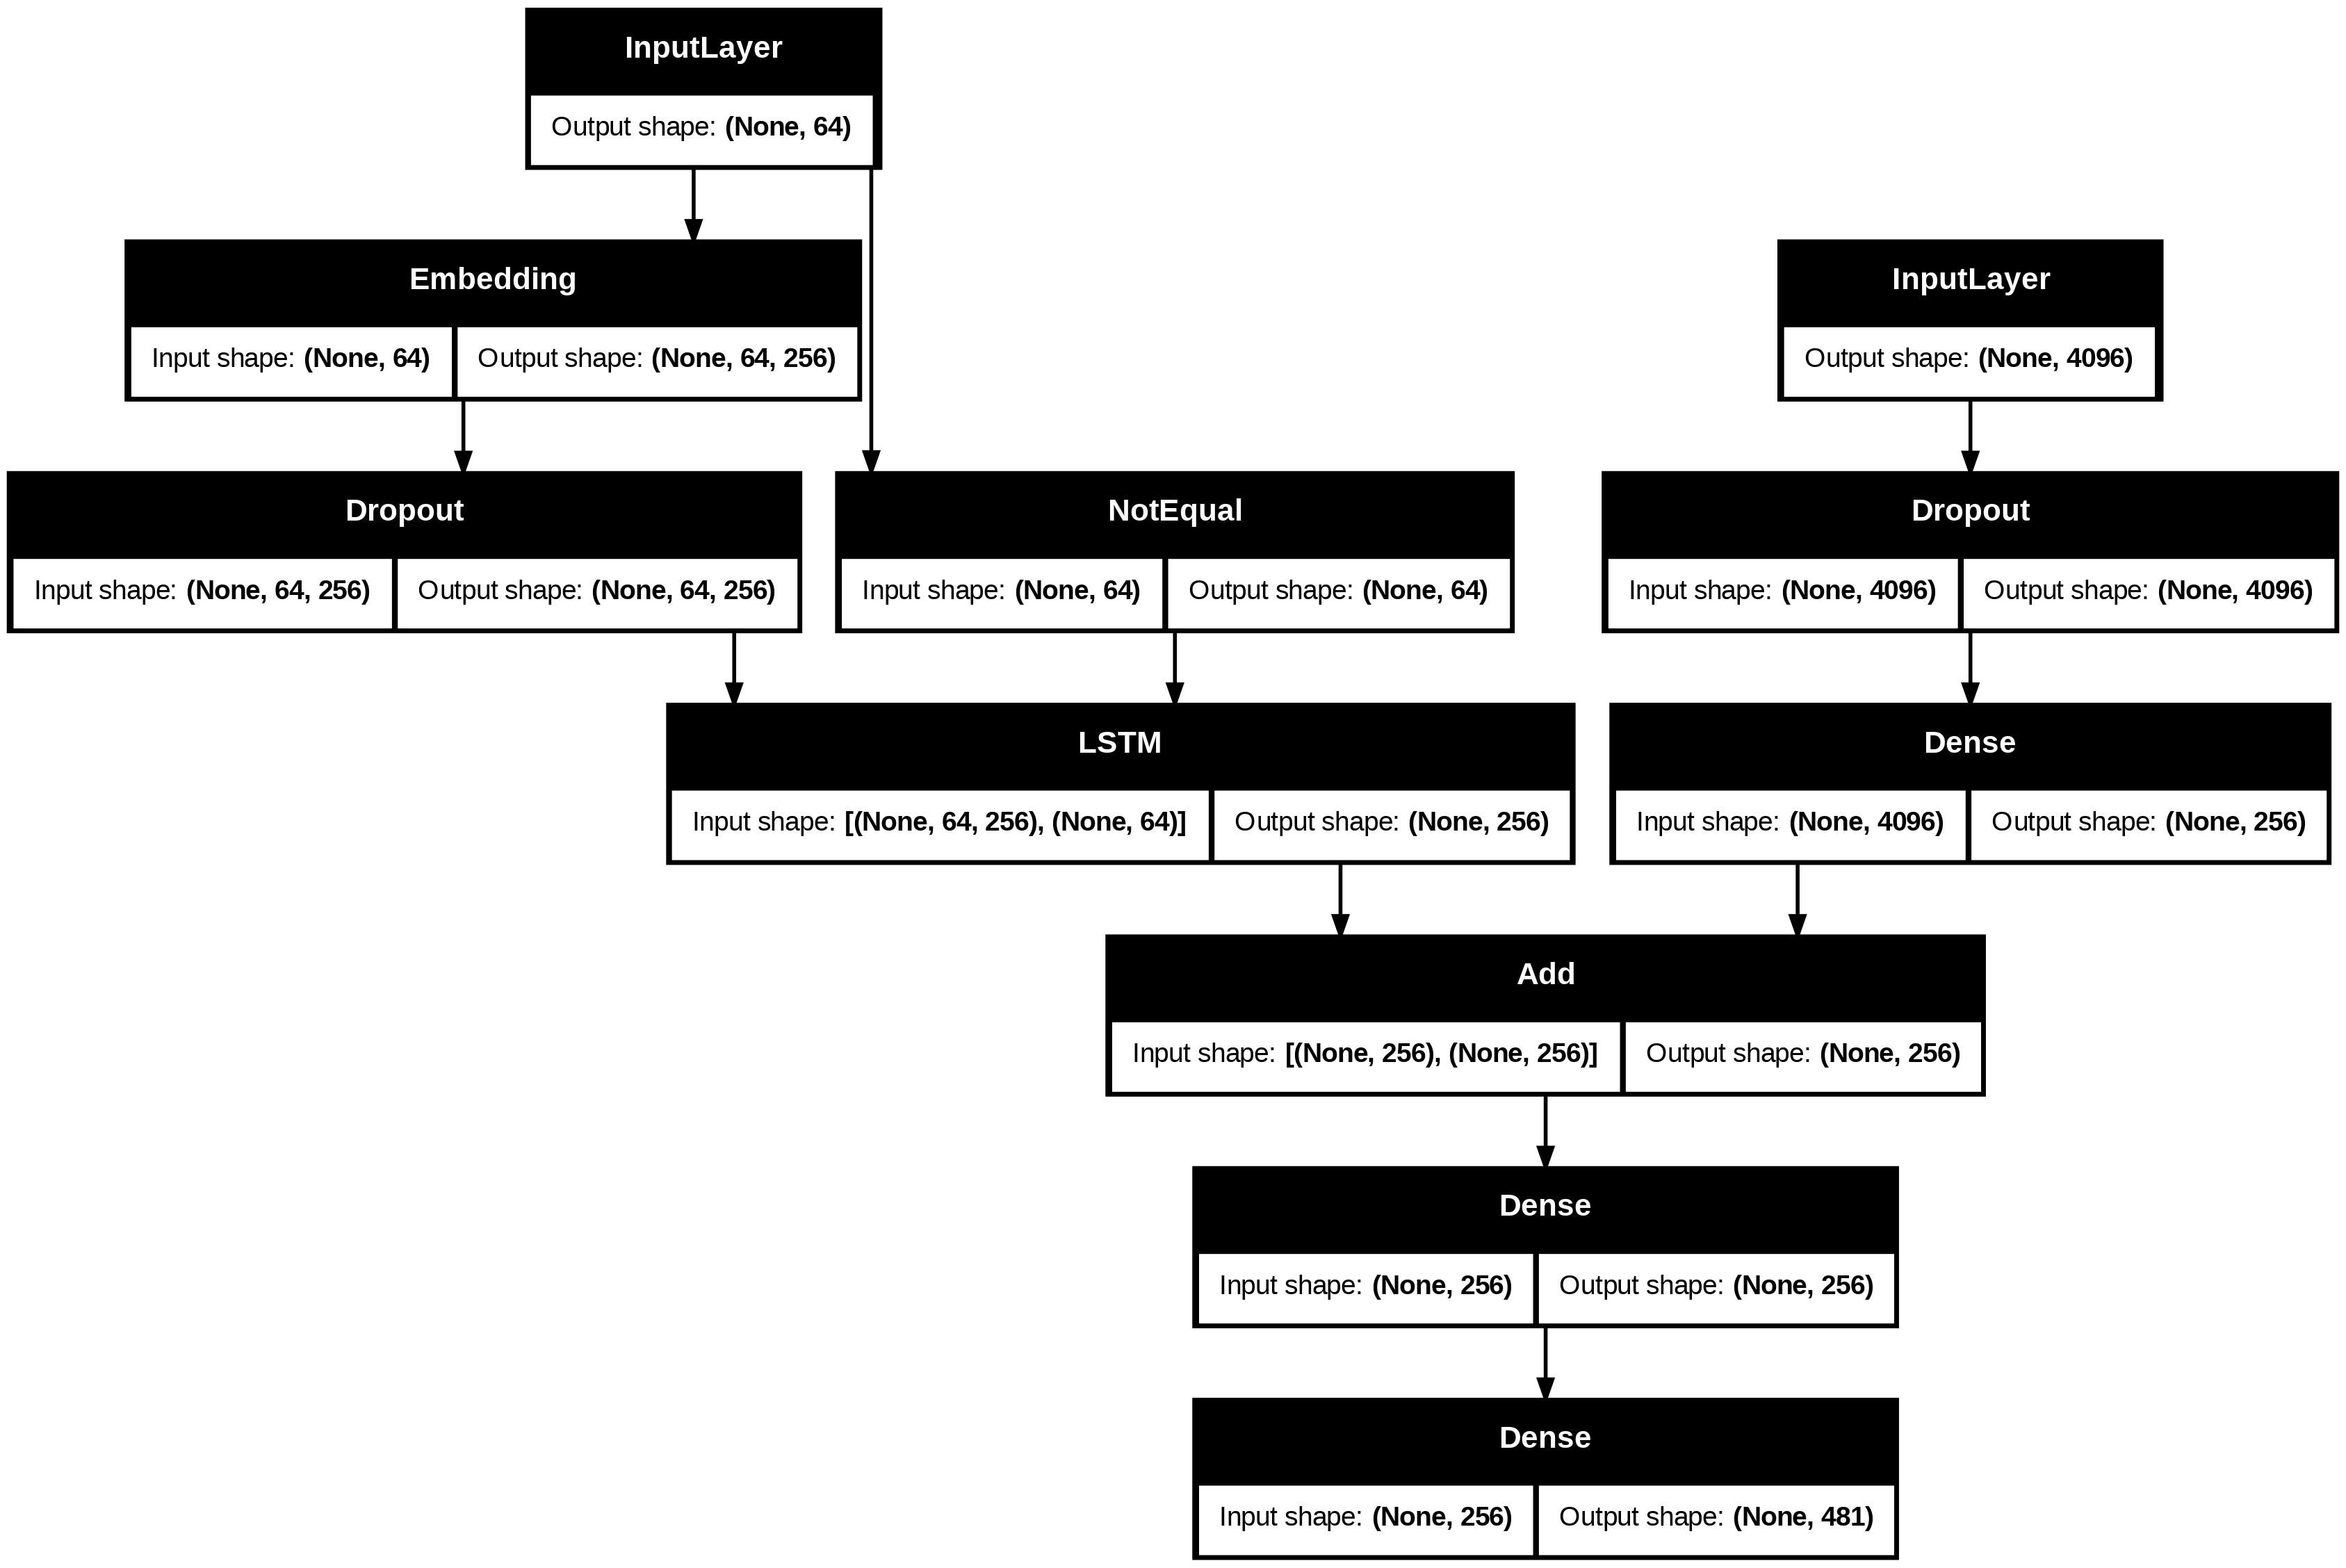

In [ ]:
# encoder model
# image feature layers

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

+ **shape=(4096,)** - output length of the features from the VGG model

+ **Dense** - single dimension linear layer array

+ **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

+ **model.compile()** - compilation of the model

+ **loss=’sparse_categorical_crossentropy’** - loss function for category outputs

+ **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

+ Model plot shows the concatenation of the inputs and outputs into a single layer

+ Feature extraction of image was already done using VGG, no CNN model was needed in this step.

# Train Model
Now let us train the model

In [ ]:
from sklearn.model_selection import train_test_split

dataset_keys = list(mapping.keys())  # Keys for all images in the dataset

# Split the dataset into training, validation, and testing sets
train_keys, val_keys = train_test_split(dataset_keys, test_size=0.2, random_state=42)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0032 - loss: 6.5260
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0885 - loss: 5.8916
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1027 - loss: 5.4979
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1027 - loss: 5.3509
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1109 - loss: 5.3194
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1100 - loss: 4.9651
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0869 - loss: 4.9093
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1012 - loss: 4.7484
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1084 - loss: 4.6425
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1036 - loss: 4.7218
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1148 - loss: 4.3534
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1230 - loss: 4.3012
Epoch 13/200


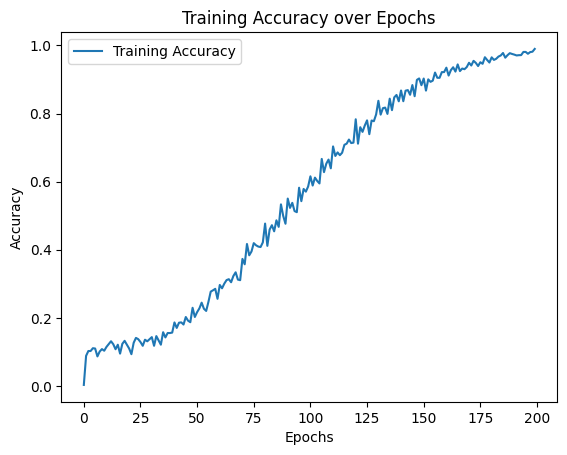

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize storage
    X1, X2, y = [], [], []
    n = 0

    while True:  # Infinite generator
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Collect inputs and outputs
                    X1.append(features[key][0])  # Features
                    X2.append(in_seq)  # Input sequence
                    y.append(out_seq)  # Output sequence

            # Yield batch when size matches batch_size
            n += 1
            if n == batch_size:
                if len(X1) == 0:  # Skip empty batches
                    continue
                # Convert to TensorFlow tensors
                X1_tensor = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)
                X2_tensor = tf.convert_to_tensor(np.array(X2), dtype=tf.float32)
                y_tensor = tf.convert_to_tensor(np.array(y), dtype=tf.float32)

                yield (X1_tensor, X2_tensor), y_tensor

                # Reset storage
                X1, X2, y = [], [], []
                n = 0


output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # Features
        tf.TensorSpec(shape=(None, max_length), dtype=tf.float32),  # Input sequences
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32),  # Output sequences
)
batch_size = 32

def safe_data_generator():
    try:
        yield from data_generator(train_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    except Exception as e:
        print(f"Error in generator: {e}")

# Create a dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    safe_data_generator,
    output_signature=output_signature,
)

# Calculate steps per epoch
steps_per_epoch = len(train_keys) // batch_size

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],  # Add accuracy metric
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=200,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
)

# Plot Training Accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()


In [ ]:
len(train_keys)

40

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9761 - loss: 0.1552
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7230 - loss: 0.8109
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9139 - loss: 0.3182
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7432 - loss: 0.7752
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7914 - loss: 0.5853
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8963 - loss: 0.3082
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9049 - loss: 0.3176
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8671 - loss: 0.3814
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8702 - loss: 0.4064
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8905 - loss: 0.3485
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9522 - loss: 0.2304
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9410 - loss: 0.2460
Epoch 13/100


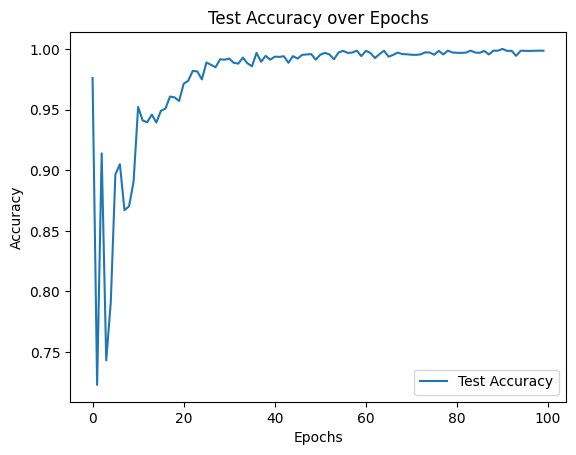

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
NameError: name 'test_keys' is not defined
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 864, in get_iterator
    return self._iterators[iterator_id]

KeyError: 0


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 866, in get_iterator
    iterator = iter(self._generator(*self._args.pop(iterator_id)))

  File "<ipython-input-25-7305867dfe5d>", line 95, in <lambda>
    lambda: safe_data_generator(test_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size),

NameError: name 'test_keys' is not defined


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_22535]

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Initialize storage
    X1, X2, y = [], [], []
    n = 0

    while True:  # Infinite generator
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Collect inputs and outputs
                    X1.append(features[key][0])  # Features
                    X2.append(in_seq)  # Input sequence
                    y.append(out_seq)  # Output sequence

            # Yield batch when size matches batch_size
            n += 1
            if n == batch_size:
                if len(X1) == 0:  # Skip empty batches
                    continue
                # Convert to TensorFlow tensors
                X1_tensor = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)
                X2_tensor = tf.convert_to_tensor(np.array(X2), dtype=tf.float32)
                y_tensor = tf.convert_to_tensor(np.array(y), dtype=tf.float32)

                yield (X1_tensor, X2_tensor), y_tensor

                # Reset storage
                X1, X2, y = [], [], []
                n = 0


output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # Features
        tf.TensorSpec(shape=(None, max_length), dtype=tf.float32),  # Input sequences
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32),  # Output sequences
)
batch_size = 32

def safe_data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    try:
        yield from data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    except Exception as e:
        print(f"Error in generator: {e}")

# Create train dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: safe_data_generator(train_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature,
)

# Calculate steps per epoch
steps_per_epoch = len(train_keys) // batch_size

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],  # Add accuracy metric
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
)

# Plot Training Accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

# Prepare test dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: safe_data_generator(test_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature,
)

# Evaluate on test dataset
steps_per_test = len(train_keys) // batch_size
test_loss, test_accuracy = model.evaluate(test_dataset, steps=steps_per_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


+ **steps = len(train) // batch_size** - back propagation and fetch the next data

+ Loss decreases gradually over the iterations

+ Increase the no. of epochs for better results

+ Assign the no. of epochs and batch size accordingly for quicker results


### You can save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.keras')

# Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

+ Convert the predicted index from the model into a word

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import keras

def load_trained_model(model_path):
    """Load a pre-trained model from an .h5 file."""
    model = load_model(model_path,safe_mode=True)
    return model

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    model=keras.models.load_model("/content/best_model.keras")
    # add start tag for generation process
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

+ Captiongenerator appending all the words for an image

+ The caption starts with 'startseq' and the model continues to predict the caption until the 'endseq' appeared

# Model Validation
Now we validate the data using BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(train_keys):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/40 [00:00<?, ?it/s]

BLEU-1: 0.219231
BLEU-2: 0.203589


+ BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

+ The reference text contains all the words appended from the captions data (actual_captions)

+ A BLEU Score more than **0.4 is considered a good result**, for a better score increase the no. of epochs accordingly.

## Visualize the Results

+ Image caption generator defined

+ First prints the actual captions of the image then prints a predicted caption of the image

In [ ]:
features

{'PMC5728079_AMS-AD-2-30747-g003': array([[0.        , 0.        , 0.32913342, ..., 2.657807  , 1.498647  ,
         1.8623605 ]], dtype=float32),
 'PMC4421890_JCIS-5-24-g008': array([[0.       , 0.       , 0.       , ..., 1.0918407, 0.       ,
         4.5011516]], dtype=float32),
 'PMC3612480_CRIM': array([[0.        , 0.69203484, 0.8928733 , ..., 1.3906631 , 0.        ,
         0.31762242]], dtype=float32),
 'PMC5404131_KITP-14-29728-g002': array([[0.        , 1.0976675 , 0.10371602, ..., 0.        , 0.        ,
         2.3404086 ]], dtype=float32),
 'PMC4265227_40119_2014_29_Fig5_HTML': array([[0.8578584, 0.       , 2.6403651, ..., 1.6169553, 0.       ,
         0.       ]], dtype=float32),
 'PMC4676479_echo-01-43-g005': array([[0.        , 0.97951156, 0.32894063, ..., 1.8810999 , 0.        ,
         0.        ]], dtype=float32),
 'PMC5392556_JoU-2017-0009-g003': array([[0.        , 1.0584545 , 0.        , ..., 0.02172023, 0.        ,
         0.        ]], dtype=float32),
 'PMC

---------------------Actual---------------------
startseq thickening of the pyloric wall with an intramural fluid collection (white arrow) black arrow represents gall bladder. endseq
--------------------Predicted--------------------
startseq thickening of the pyloric wall with an intramural fluid collection white arrow black arrow represents gall bladder endseq


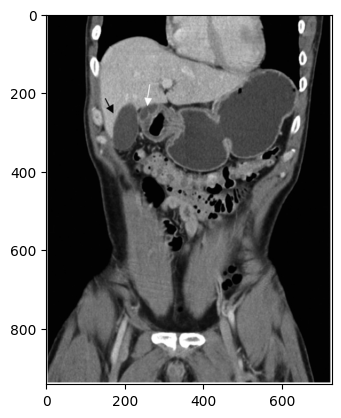

In [ ]:
generate_caption("PMC5566631_gov037f2.jpg")

---------------------Actual---------------------
startseq axial image of the abdominal ct scan showing radiation dose distribution within the right kidney mass (pink red and yellow lines) with the right kidney highlighted in green and the adjacent bowel in blue colors. endseq
--------------------Predicted--------------------
startseq computed tomography showing the mass endseq


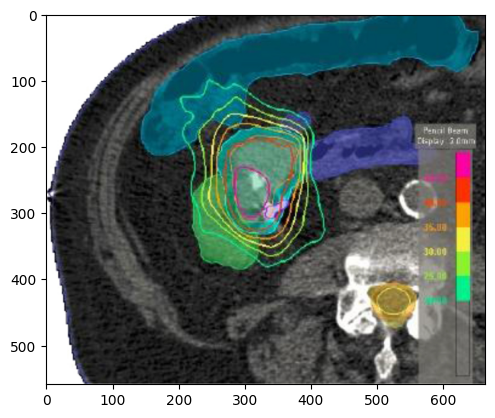

In [ ]:
generate_caption("PMC4719793_gr3.jpg")

# Final Thoughts

+ Training the model by increasing the no. of epochs can give better and more accurate results.

+ Processing large amount of data can take a lot of time and system resource.

+ The no. of layers of the model can be increased if you want to process large dataset like flickr32k.



**In this project , we have built an Image Caption Generator exploring the Flickr Dataset as an advanced deep learning project using different models from image extraction and text based processing.**

In [ ]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9e72c6b23e47a1eda62e3015976e1f48bb122f4e2f6e933b8633dbd56e1e2265
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer
from tqdm.notebook import tqdm

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Prepare lists for actual and predicted captions
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

# Compute ROUGE scores
for key in tqdm(train_keys):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # Get all actual captions for this key
    actual_captions = [caption for caption in captions]

    # Calculate ROUGE scores for each actual caption against the predicted one
    for actual_caption in actual_captions:
        scores = scorer.score(actual_caption, y_pred)

        # Append scores for averaging later
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

# Average the ROUGE scores across all captions
average_rouge1 = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
average_rouge2 = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
average_rougeL = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])

# Print the ROUGE scores
print(f"Average ROUGE-1 Score: {average_rouge1:.4f}")
print(f"Average ROUGE-2 Score: {average_rouge2:.4f}")
print(f"Average ROUGE-L Score: {average_rougeL:.4f}")

  0%|          | 0/40 [00:00<?, ?it/s]

Average ROUGE-1 Score: 0.9671
Average ROUGE-2 Score: 0.9524
Average ROUGE-L Score: 0.9671


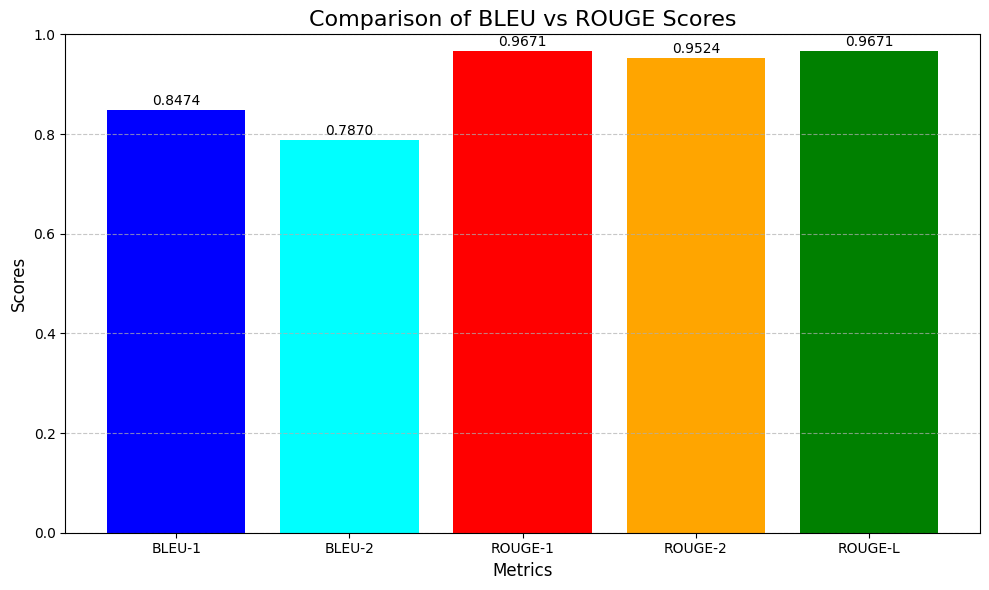

In [ ]:
import matplotlib.pyplot as plt

# Scores from BLEU and ROUGE evaluations
bleu_scores = {
    'BLEU-1': corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)),
    'BLEU-2': corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)),
}

rouge_scores = {
    'ROUGE-1': average_rouge1,
    'ROUGE-2': average_rouge2,
    'ROUGE-L': average_rougeL,
}

# Combine scores into a dictionary for easy plotting
scores = {**bleu_scores, **rouge_scores}

# Separate keys and values for plotting
labels = list(scores.keys())
values = list(scores.values())

# Plot the scores
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'cyan', 'red', 'orange', 'green'])

# Annotate the bars with their respective values
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)

# Add title and labels
plt.title("Comparison of BLEU vs ROUGE Scores", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.ylim(0, 1)  # Assuming the scores are normalized between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


  0%|          | 0/40 [00:00<?, ?it/s]

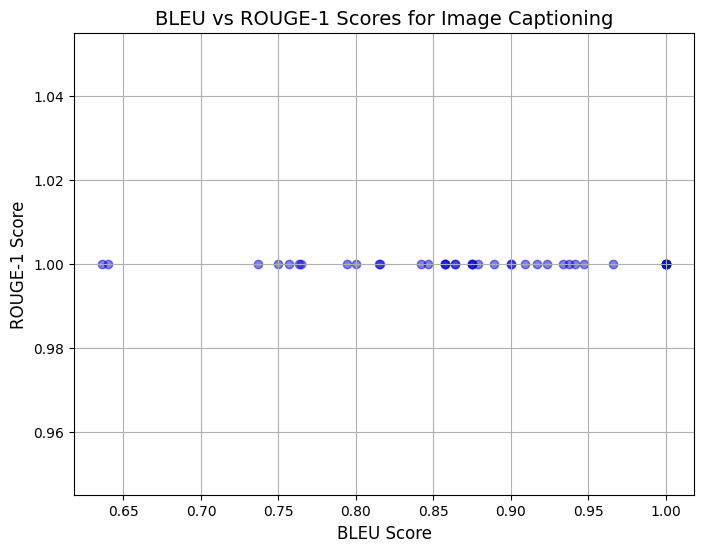

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Initialize the scorer for ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

# Collect BLEU and ROUGE scores
bleu_scores_1 = []
rouge_scores_1 = []
for key in tqdm(train_keys):
    # Get actual captions and predicted caption
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # Split into words for BLEU
    actual_captions = [caption.split() for caption in captions]
    y_pred_words = y_pred.split()

    # Compute BLEU score (compare predicted caption with the actual captions)
    bleu_1 = corpus_bleu([actual_captions], [y_pred_words], weights=(1.0, 0, 0, 0))
    bleu_scores_1.append(bleu_1)

    # Compute ROUGE score
    scores = scorer.score(captions[0], y_pred)  # Compare with first caption
    rouge_scores_1.append(scores['rouge1'].fmeasure)

# Convert lists to numpy arrays for plotting
bleu_scores_1 = np.array(bleu_scores_1)
rouge_scores_1 = np.array(rouge_scores_1)

# Plot BLEU vs ROUGE as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(bleu_scores_1, rouge_scores_1, color='blue', alpha=0.5)
plt.title("BLEU vs ROUGE-1 Scores for Image Captioning", fontsize=14)
plt.xlabel("BLEU Score", fontsize=12)
plt.ylabel("ROUGE-1 Score", fontsize=12)
plt.grid(True)
plt.show()